In [1]:
# Cálcula el porcentaje de error entre dos series de máximos anuales.

import itertools
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [2]:
# Cantidad de celdas a eliminar del borde.
k = 1

# Archivos a evaluar.
eval = [ [0, 2], [0, 7], [4, 5], [5, 6], [8, 6] ]
n = 3
i = eval[n][0]
j = eval[n][1]
var = "wenzel"
#var = "medido"

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_era5_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "prec_mroc_hist_hist_days", "prec_mroc_h20a_hist" ]

fname = name[i] + "_" + name[j]
dir = "../results/comp/" + fname + "/"

# Si no existe la carpeta, la crea.
if not os.path.exists(dir):
    os.mkdir(dir)

if var == "wenzel":
    path_orig   = "../results/" + name[i] + "/" + name[i] + "_idf_valores.nc" 
    path_comp   = "../results/" + name[j] + "/" + name[j] + "_idf_valores.nc" 
if var == "medido":
    path_orig   = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
    path_comp   = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 
path_orig_s = "../results/" + name[i] + "/" + name[i] + "_stats.nc" 
path_comp_s = "../results/" + name[j] + "/" + name[j] + "_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

# Estadísticas de los valores originales.
ds_orig.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,1.029600e+06
mean,5.821205e+01
std,6.404515e+01
min,3.484559e+00
25%,2.672901e+01
50%,4.212181e+01
75%,6.797705e+01
max,3.376506e+03


In [3]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf(dir + fname + "_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre prec_mroc_hist_hist y prec_mroc_2040_2040
count: 171600.00
mean: 0.03
std: 0.30
min: -0.91
25%: -0.14
50%: 0.03
75%: 0.18
max: 2.36


In [4]:
# Error en el total de precipitación.
prec_e = ( comp_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum()
    / orig_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum() - 1 )

prec_e.describe()

,PRECIPITACION
count,14300.000000
mean,0.022678
std,0.075215
min,-0.262462
25%,-0.021515
50%,0.022833
75%,0.063242
max,0.399005


In [5]:
# Error total.
if var == "medido":
    ds_comp = ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
    ds_orig = ds_orig.drop( ["AÑO", "PROBABILIDAD"] )
error = ( ( ds_comp - ds_orig )
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
#error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
#    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ) )
#    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf(dir + fname + ".nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre prec_mroc_hist_hist y prec_mroc_2040_2040
count: 1029600.00
mean: 0.14
std: 0.90
min: -0.89
25%: -0.06
50%: 0.08
75%: 0.24
max: 111.45


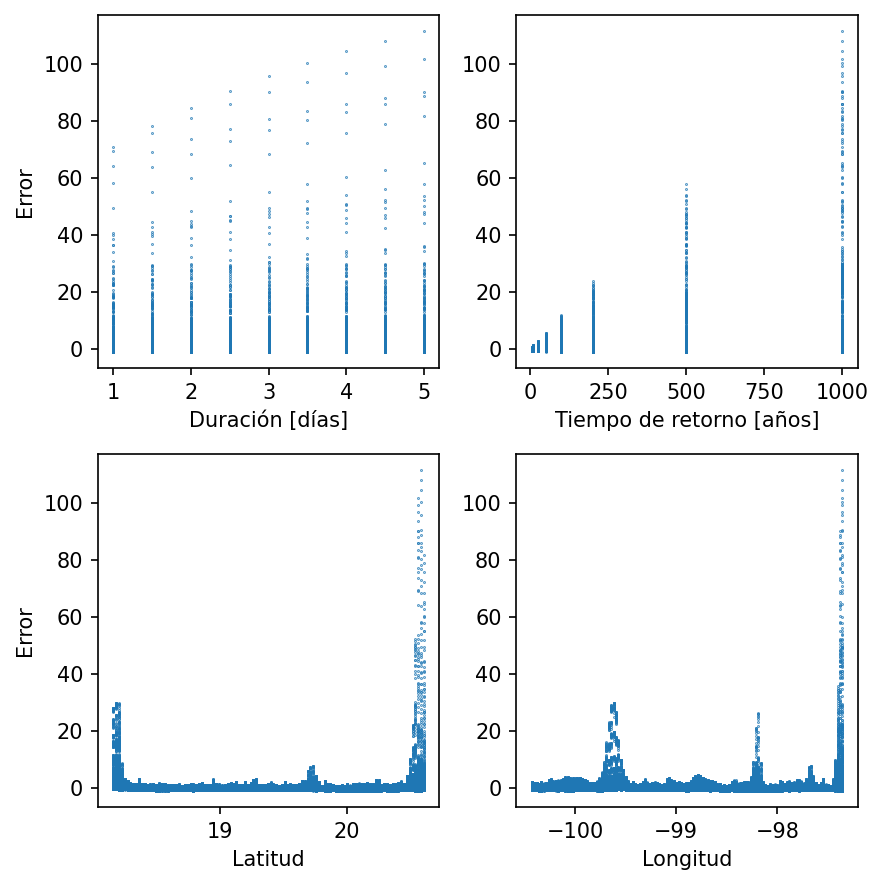

In [6]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

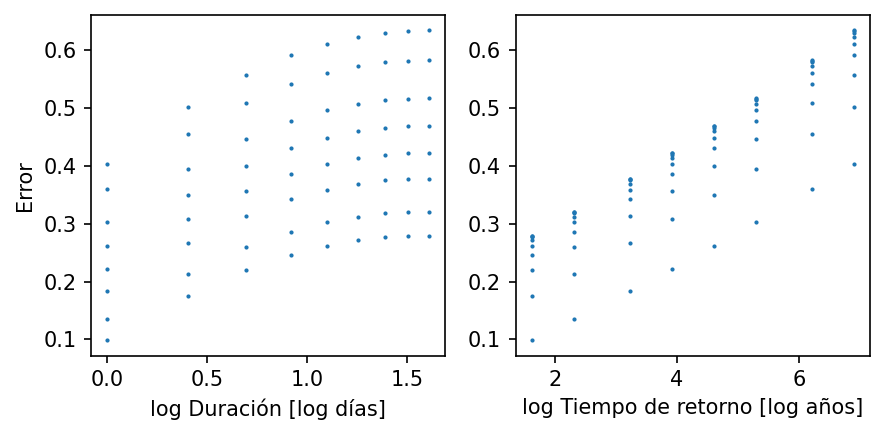

In [7]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 15
N = 15
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
#ax[0].scatter( f_xs.reset_index()["DURACION"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
#ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( np.log( df_xs.reset_index()["TIEMPO_RETORNO"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
#ax[0].set_xlabel(f"Duración [días]")
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
#ax[1].set_xlabel(f"Tiempo de retorno [años]")
ax[1].set_xlabel(f"log Tiempo de retorno [log años]")

fig.tight_layout()
plt.show()

In [8]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log(  df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.log(  df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              "T_1",
                              #"T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1460.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           3.45e-57
Time:                        22:09:13   Log-Likelihood:                 180.50
No. Observations:                  72   AIC:                            -355.0
Df Residuals:                      69   BIC:                            -348.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.008      0.281      0.780      -0.013       0.018
D_1            0.1240      0.005     26.406      0.000       0.115       0.133
T_1            0.0645      0.001     47.140      0.000       0.062       0.067
==============================================================================
Omnibus:                        6.905   Durbin-Watson:                   0.647
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                5.430
Skew:                          -0.559   Prob(JB):                       0.0662
Kurtosis:                       2.253   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Intentamos obtener un valor para todo el dominio.

# Error normalizado
#error_n = ( error / error.sel(DURACION = 1, TIEMPO_RETORNO = 5 )
#    ).to_dataframe().droplevel(level = (0, 1) ).reset_index()
# Error sin normalizar.
error_n = df_e.copy().reset_index()

# Regresión múltiple logarítmica.
X = sm.add_constant( np.log( error_n[["DURACION", "TIEMPO_RETORNO"]] ) )
Y = error_n[["P_ERROR"]]
model = sm.OLS(Y,X)
results = model.fit()
# Ajuste de la regresión.
results.rsquared_adj

0.0027898695173562693

In [10]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR",
        "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR",
        #"C_TRET",
        "P_CONST",
        "P_LOG_DUR",
        "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #"P_DUR",
        #"P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            #"DURACION",
            #"TIEMPO_RETORNO",
            "LOG_DURACION",
            "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

for c in df_s.columns:
    df_s[c] = df_s[c].astype(float)

# Guardamos el archivo.
df_s.to_xarray().to_netcdf(dir + fname + "_reglin.nc")

# Estadísticas de los valores de la regresión.
df_s.describe()

,CONST,C_LOG_DUR,C_LOG_TRET,P_CONST,P_LOG_DUR,P_LOG_TRET,ADJ_R_SQUARED,P_F_STAT,P_JB,COND_NO,P_BP
count,14300.000000,14300.000000,14300.000000,1.430000e+04,1.430000e+04,1.430000e+04,14300.000000,1.430000e+04,1.430000e+04,1.430000e+04,1.430000e+04
mean,0.024168,-0.003630,0.027523,1.981668e-02,3.884101e-02,8.707199e-03,0.924975,1.002451e-03,1.177532e-01,1.702459e+01,1.179016e-01
std,0.985922,0.130716,0.337975,1.034106e-01,1.471059e-01,7.173808e-02,0.145679,2.285798e-02,1.610482e-01,7.105676e-15,2.051657e-01
min,-48.258763,-0.554213,-0.144043,7.358015e-200,2.497587e-164,4.463508e-149,-0.027544,2.502867e-163,3.055579e-16,1.702459e+01,2.216050e-12
25%,0.010025,-0.046877,-0.040748,3.870914e-49,5.024881e-36,1.195652e-71,0.935750,8.417348e-73,3.192575e-02,1.702459e+01,8.646962e-04
50%,0.085662,-0.009485,-0.003689,3.937298e-31,4.208535e-18,5.185137e-59,0.980755,2.404218e-60,4.178450e-02,1.702459e+01,9.192522e-03
75%,0.155680,0.028551,0.044468,1.936937e-14,7.137247e-07,1.023331e-37,0.991619,2.776508e-42,1.167548e-01,1.702459e+01,1.393499e-01
max,0.512547,6.370404,15.119267,9.997375e-01,9.940992e-01,9.987947e-01,0.999980,9.527953e-01,9.958547e-01,1.702459e+01,9.970518e-01


In [25]:
# Calcula la intensidad de precipitación corregida.

T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[2],
      error["P_ERROR"].shape[3] ) )[:, :, :,
    0:error["P_ERROR"].shape[3]]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[3],
      error["P_ERROR"].shape[2] ) )[:, :, :,
    0:error["P_ERROR"].shape[2]], 3, 2 ) 

B0 = np.tile( np.expand_dims( df_s.to_xarray()["CONST"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B1 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_DUR"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B2 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_TRET"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )

# Predicción.
if var == "wenzel":
    D = np.swapaxes( D, 0, 1 )
    T = np.swapaxes( T, 0, 1 )
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_orig.copy()
ds_corr["P_ERROR"] = ( list( ds_corr.dims ), REG ) 
ds_corr["INTENSIDAD"] = ds_corr["INTENSIDAD"] * ( ds_corr["P_ERROR"] +  1 )

# Guardamos.
ds_corr.to_netcdf(dir + fname + "_corr.nc")

# Estadísticas de los valores de la regresión.
ds_corr.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,1.029600e+06
mean,6.519162e+01
std,2.364710e+02
min,-7.443760e+02
25%,2.918743e+01
50%,4.577499e+01
75%,7.290662e+01
max,3.472114e+04


In [26]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Float64Index([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64', name='DURACION')


INTENSIDAD    P_ERROR
LATITUD   LONGITUD                         
18.157814 -99.691284   -4.726412  -1.604283
          -99.667465  -13.728965  -2.757341
          -99.643646  -20.379306  -3.654937
          -99.619827  -20.910487  -3.748070
          -99.596008  -14.991416  -2.976891
          -99.572189   -5.275919  -1.673826
          -99.548378   -0.106611  -1.010961
18.180450 -99.691284   -3.133111  -1.418551
          -99.667465  -12.214892  -2.619454
          -99.643646  -21.185649  -3.863042
          -99.619827  -22.237742  -4.034043
          -99.596008  -16.270326  -3.229946
          -99.572189   -5.314178  -1.705194
18.203079 -99.667465   -2.913792  -1.326374
          -99.643646  -14.499341  -2.775257
          -99.619827  -19.894743  -3.533855
          -99.596008  -15.497361  -3.054003
          -99.572189   -4.661841  -1.556857
          -98.238350   -0.840431  -1.076887
          -98.214539   -7.487028  -1.960400
          -98.190720  -11.637522  -2.661876
18.225700 -99.596008   -0.501522  -1.026681
20.495155 -97.380882   -5.056353  -1.171663
          -97.357063   -5.243909  -1.198501
20.517464 -97.404701  -13.499176  -1.458636
          -97.380882  -44.132973  -2.780992
          -97.357063  -43.431740  -2.847719
20.539772 -97.404701  -56.657416  -3.074039
          -97.380882 -124.485846  -5.726950
          -97.357063 -111.333416  -5.400220
20.562073 -97.428520  -10.277234  -1.344187
          -97.404701  -84.399113  -4.069144
          -97.380882 -249.314576 -10.297277
          -97.357063 -276.687641 -11.528548
20.584373 -97.428520  -10.493044  -1.366979
          -97.404701  -80.886693  -3.928055
          -97.380882 -242.133421  -9.850473
          -97.357063 -305.365225 -12.409685
20.606667 -97.428520   -8.222743  -1.276427
          -97.404701  -65.295025  -3.377608
          -97.380882 -161.747547  -6.918735
          -97.357063 -205.926908  -8.730638

In [27]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf(dir + fname + "_espacial.nc")